In [2]:
import os
import pandas as pd
import numpy as np
import librosa as lr
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import torchaudio

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

mode = "local"

input_dir = ""
output_dir = ""

if mode == "local":
    input_dir = "../../"
    output_dir = ""
    features_dir = f"{input_dir}/extracted_features"

if mode == "kaggle":
    input_dir = "/kaggle/input/depression-audio/daic-woz-dataset"
    features_dir = "/kaggle/input/depression-audio/extracted_features/extracted_features"
    output_dir = "/kaggle/working"

DATASET_DIR = f"{input_dir}/extracted_audio"
DATAINFO_DIR = f"{input_dir}/dataset_info"
MELSPECT_DIR = f"{features_dir}/mel_spectograms"

In [35]:
print(torch.__version__)
print(torchaudio.__version__)

2.4.0+cpu
2.4.0+cpu


In [ ]:
audio_path = os.path.join(DATASET_DIR, "train", "302_AUDIO.wav")
wfm, sr = torchaudio.load(audio_path)
sr, wfm.shape

# Data Preparation

In [5]:
def create_melspectogram(files, split_type):
    melspectograms = []
    for file in files:
        audio_path = os.path.join(DATASET_DIR, split_type, file)
        wfm, sr = torchaudio.load(audio_path)
        melspectogram = torchaudio.transforms.MelSpectrogram(
            n_fft=1024, n_mels=128, hop_length=512, sample_rate=sr, norm="slaney"
        )(wfm)
        melspectogram = melspectogram.to(torch.float16)
        melspectograms.append(melspectogram)
    return melspectograms

In [37]:
train_files = sorted(os.listdir(os.path.join(DATASET_DIR, "train")))

train_spectograms = create_melspectogram(train_files, "train")

In [38]:
print(len(train_spectograms), len(train_files))

274 274


In [13]:
torch.save(train_spectograms, f"{output_dir}/raw_train_spectograms.pkl")

## Splitting spectograms into segments

Each segement will be of specific length to avoid huge padding. Since largest spectogram is of shape 67856 whereas smallest is of 3459. Starting with 4096 as segment length. 4096 segment will correspond to approximate 2 minutes of audio.

In [5]:
train_spectograms = torch.load("/kaggle/input/depression-audio/raw_train_melspectograms.pkl")

/tmp/ipykernel_30/2674431718.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_spectograms = torch.load("/kaggle/input/depression-audio/raw_train_melspectograms.pkl"

In [7]:
all_shapes = [spect.shape[-1] for spect in train_spectograms]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


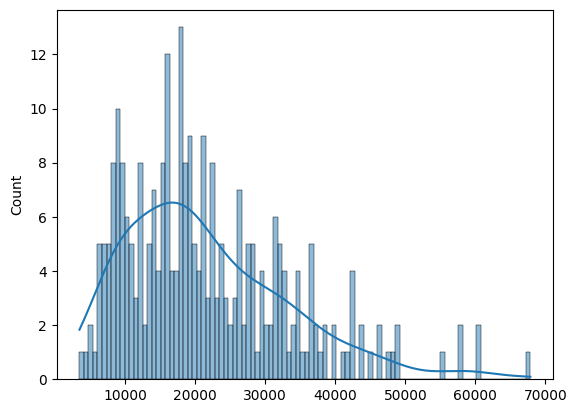

In [8]:
sns.histplot(all_shapes, bins=100, kde=True)
plt.show()

In [39]:
WINDOW_SIZE = 8192
OVERLAP_SAMPLES = 1024 # this much samples will be overlapped from the end of particular window
SKIP = WINDOW_SIZE - OVERLAP_SAMPLES
print(SKIP)

7168


In [27]:
def segment_spectograms(all_spectograms, WINDOW_SIZE, SKIP, dataframe, split_type):
    files = sorted(os.listdir(os.path.join(DATASET_DIR, split_type)))
    # print(files[:20])
    # print(f"Total files in {split_type} split: {len(files)}")
    
    all_labels = []
    all_segments = []
    for i, spectogram in enumerate(all_spectograms):
        segments = []
        
        # Pad the spectrogram if its length isn't a multiple of WINDOW_SIZE
        if spectogram.shape[-1] % WINDOW_SIZE != 0:
            pad_len = WINDOW_SIZE - (spectogram.shape[-1] % WINDOW_SIZE)
            spectogram = torch.nn.functional.pad(spectogram, (0, pad_len))
            # print(spectogram.shape)
        
        number_of_segments = 0
        # Segmenting the spectrogram
        for j in range(0, spectogram.shape[-1] - WINDOW_SIZE+1, SKIP):
            segment = spectogram[:, :, j:j+WINDOW_SIZE]
            segments.append(segment)
            number_of_segments += 1
        
        current_file = files[i]
#         print("Current File:", current_file)
#         print("Number of Segments:", number_of_segments)
        participant_id = int(current_file.split("_")[0])
        
        # if current file is augmented, then we need to get the augment type
        # check if B or P or S in present in current file
        augment_type = ""
        if "B" in current_file:
            augment_type = "B"
        elif "P" in current_file:
            augment_type = "P"
        elif "S" in current_file:
            augment_type = "S"
            
        if augment_type != "":
            participant_id = str(participant_id) + "_" + augment_type
            
#         print("Participant ID:", participant_id)
        
        # extract the dataframe row for this participant
        df_row = dataframe[dataframe['Participant_ID'] == participant_id]
        label = df_row['PHQ_Binary'].values[0]
#         print("Label:", label)
        # print(df_row)
        
        # replicate the label for each segment
        all_labels.extend([label]*number_of_segments)
        
        # Stack segments into a single tensor
        spectogram = torch.stack(segments, dim=1)
#         print(spectogram.shape)
        
        all_segments.append(spectogram)
        
#         print("--------------------")

    return all_segments, np.array(all_labels)


In [44]:
all_segments, all_labels =  segment_spectograms(train_spectograms, WINDOW_SIZE, SKIP, train_df, "train")

In [45]:
total_segments = sum([segment.shape[1] for segment in all_segments])
total_segments

866

In [47]:
len(all_segments), len(all_labels), len(train_spectograms)

(274, 866, 274)

## Stack all the segments

In [48]:
train_stacked_seg_spect = torch.cat(all_segments, dim=1)
train_stacked_seg_spect.shape

torch.Size([1, 866, 128, 8192])

In [49]:
train_stacked_seg_spect = torch.squeeze(train_stacked_seg_spect, dim=0)
train_stacked_seg_spect.shape

torch.Size([866, 128, 8192])

In [50]:
torch.save(train_stacked_seg_spect, f"{output_dir}/train_stacked_seg_spect.pkl")
np.save("train_labels.npy", all_labels)

# Pipline for creating Mel Spectogram

Just putting all functions in single functions so that mel spectogram can be created and stored at once

In [15]:
def create_melspect_save(split_type):
    files = sorted(os.listdir(os.path.join(DATASET_DIR, split_type)))
    melspectograms = create_melspectogram(files, split_type)
    
    if len(melspectograms) != len(files):
        raise Exception("Mismatch in number of samples of melspectograms and number of files")
        
    WINDOW_SIZE = 8192
    OVERLAP_SAMPLES = 1024 # this much samples will be overlapped from the end of particular window
    SKIP = WINDOW_SIZE - OVERLAP_SAMPLES
    
    if split_type == "train":
        dataframe = pd.read_csv(f"{DATAINFO_DIR}/{split_type}_split_augmented.csv")
    else:
        dataframe = pd.read_csv(f"{DATAINFO_DIR}/{split_type}_split.csv")
    
    all_segments, all_labels =  segment_spectograms(melspectograms, WINDOW_SIZE, SKIP, dataframe, split_type)
    
    if len(all_segments) != len(melspectograms):
        raise Exception("Mismatch in number of samples of all segments and melspectograms")
        
    total_segments = sum([segment.shape[1] for segment in all_segments])
    
    if total_segments != len(all_labels):
        raise Exception("Mismatch between count of sum of all segments and total samples of all labels")
        
    stacked_seg_spect = torch.cat(all_segments, dim=1)

    stacked_seg_spect = torch.squeeze(stacked_seg_spect, dim=0)

    torch.save(stacked_seg_spect, f"{output_dir}/{split_type}_stacked_seg_spect.pkl")
    np.save(f"{split_type}_labels.npy", all_labels)
    
    return stacked_seg_spect, all_labels

In [9]:
train_spectograms, train_labels = create_melspect_save("train")

In [13]:
train_spectograms.shape, np.array(train_labels).shape

(torch.Size([866, 128, 8192]), (866,))

In [26]:
dev_spectograms, dev_labels = create_melspect_save("dev")
dev_spectograms.shape, dev_labels.shape

Participant ID: 300
Participant ID: 301
Participant ID: 306
Participant ID: 317
Participant ID: 320
Participant ID: 321
Participant ID: 331
Participant ID: 334
Participant ID: 336
Participant ID: 343
Participant ID: 344
Participant ID: 347
Participant ID: 350
Participant ID: 365
Participant ID: 371
Participant ID: 373
Participant ID: 374
Participant ID: 381
Participant ID: 382
Participant ID: 388
Participant ID: 393
Participant ID: 401
Participant ID: 402
Participant ID: 408
Participant ID: 412
Participant ID: 415
Participant ID: 423
Participant ID: 425
Participant ID: 431
Participant ID: 433
Participant ID: 435
Participant ID: 437
Participant ID: 441
Participant ID: 442
Participant ID: 448
Participant ID: 451
Participant ID: 454
Participant ID: 455
Participant ID: 465
Participant ID: 468
Participant ID: 473
Participant ID: 475
Participant ID: 479
Participant ID: 480
Participant ID: 484
Participant ID: 486
Participant ID: 617
Participant ID: 627
Participant ID: 632
Participant ID: 653


(torch.Size([155, 128, 8192]), (155,))

In [28]:
test_spectograms, test_labels = create_melspect_save("test")
test_spectograms.shape, test_labels.shape

(torch.Size([141, 128, 8192]), (141,))

# Playground